In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, tree
from sklearn import ensemble


import warnings
warnings.filterwarnings("ignore")

In [27]:
train_url = 'https://raw.githubusercontent.com/taoxinyyyun/Data144/main/data-144-kaggle-competition/train.csv'
test_url = 'https://raw.githubusercontent.com/taoxinyyyun/Data144/main/data-144-kaggle-competition/test.csv'

df_train = pd.read_csv(train_url)
df_test = pd.read_csv(test_url)

In [3]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [28]:
train = df_train.drop(columns=['Cabin'])
train.dropna(inplace=True)
train['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [4]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


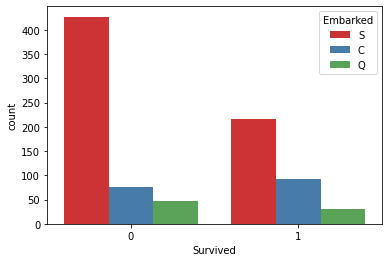

In [8]:
# Perform some basic EDA to visualize the features.
# Is there a relationship between embarkment and survival?
sns.countplot(x='Survived', data=df_train, hue="Embarked", palette="Set1")

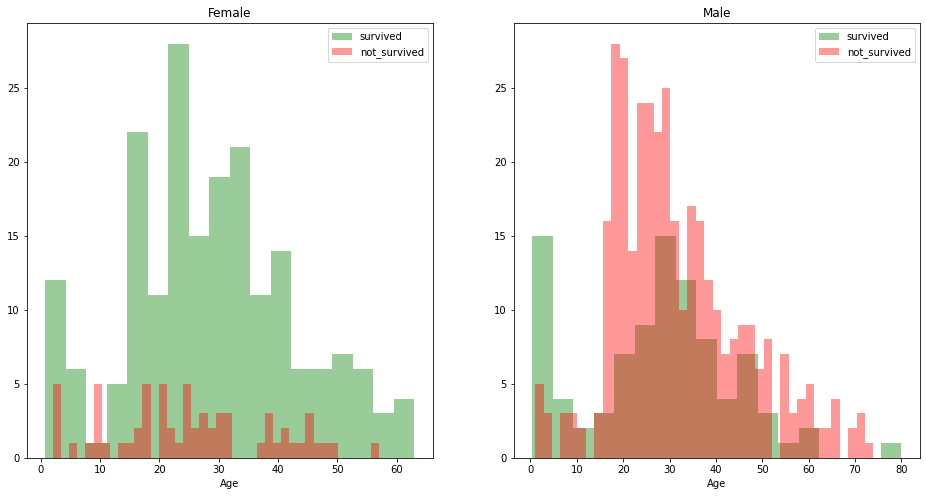

In [9]:
# Age and Gender.
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
females = df_train[df_train['Sex']=='female']
men = df_train[df_train['Sex']=='male']
ax = sns.distplot(females[females['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[0], kde =False, color="green")
ax = sns.distplot(females[females['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male')

In [10]:
# Model 1. Preprocessing.
X_train = df_train[['Name','Pclass', 'Sex', 'Age','SibSp', 'Parch','Fare','Embarked']]
y_train = df_train['Survived']

X_test = df_test[['Name','Pclass', 'Sex', 'Age','SibSp', 'Parch','Fare','Embarked']]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2)

In [13]:
# Data preprocessing.
sc = StandardScaler()

def process_df(df):
  df['Age'].fillna(np.median(df['Age'].dropna()), inplace=True)
  # Using random generated number to fill age null values.
  # mean = df["Age"].mean()
  # std = df["Age"].std()
  # is_null = df["Age"].isnull().sum()
  # rand_age = np.random.randint(mean - std, mean + std, size = is_null)
  # age_slice = df["Age"].copy()
  # age_slice[np.isnan(age_slice)] = rand_age
  # df["Age"] = age_slice
  # df["Age"] = df["Age"].astype(int)

  df['Fare'].fillna(df['Fare'].median(), inplace=True)
  df['Embarked'].fillna(df['Embarked'].mode(), inplace=True)
  d_sex = {'male':0, 'female':1}
  df = df.replace({'Sex':d_sex})
  df = pd.get_dummies(df, prefix=['Embarked'], columns=['Embarked'])
  df = pd.get_dummies(df, prefix=['Pclass'], columns=['Pclass'])

  return df

# Create new features.
def add_features(df):
  df.loc[df['SibSp'] + df['Parch'] > 0, 'travelled_alone'] = 0
  df.loc[df['SibSp'] + df['Parch'] == 0, 'travelled_alone'] = 1
  df['travelled_alone'] = df['travelled_alone'].astype(int)
  return df

X_train_2 = process_df(X_train)
X_val_1 = process_df(X_val)
X_test_1 = process_df(X_test)

datasets = [X_train_2, X_val_1, X_test_1]

for df in datasets:
  df = add_features(df)

In [14]:
data = [X_train_2, X_val_1, X_test_1]

for df in data:
  df['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
  df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  df['Title'] = df['Title'].replace('Mlle', 'Miss')
  df['Title'] = df['Title'].replace('Ms', 'Miss')
  df['Title'] = df['Title'].replace('Mme', 'Mrs')
  df['Title'] = df['Title'].fillna("None")

X_train_2 = pd.get_dummies(X_train_2, columns = ['Title'])
X_train_2 = X_train_2.drop(['Name'], axis=1)

X_val_1 = pd.get_dummies(X_val_1, columns = ['Title'])
X_test_1 = pd.get_dummies(X_test_1, columns = ['Title'])

X_val_1 = X_val_1.drop(['Name'], axis=1)
X_test_1 = X_test_1.drop(['Name'], axis=1)

# normalization
train_numerical_features = ['Fare','Age','SibSp','Parch']

data_numerical = [X_train_2, X_val_1, X_test_1]

for df in data_numerical:
  df[train_numerical_features] = sc.fit_transform(df[train_numerical_features])

In [15]:
from sklearn.linear_model import LogisticRegressionCV
logistic_model = LogisticRegressionCV(solver='liblinear',Cs=5, cv=5, random_state=42)
cv_model = logistic_model.fit(X_train_2, y_train)

print(accuracy_score(y_train, cv_model.predict(X_train_2)))

0.8356741573033708


In [18]:
# Use grid search to tune the hyperparameters.
parameter_space = {
    'penalty' : ['l1', 'l2'],
    'Cs': [0.01,0.1,1,5,10],
    'solver' : ['liblinear','lbfgs','newton-cg','sag']},

logistic_model = LogisticRegressionCV()
lm_gs = GridSearchCV(logistic_model, parameter_space, cv=10)
lm_gs.fit(X_train_2, y_train)

print('Best parameters found:\n', lm_gs.best_params_)

Best parameters found:
 {'Cs': 5, 'penalty': 'l1', 'solver': 'liblinear'}


In [19]:
# Training and validation accuracy.
print(accuracy_score(y_train, lm_gs.predict(X_train_2)))
print(accuracy_score(y_val, lm_gs.predict(X_val_1)))

0.8342696629213483
0.8268156424581006


In [20]:
# Generating test predictions.
predictions = lm_gs.predict(X_test_1)

In [21]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [22]:
submission = pd.DataFrame(index=df_test['PassengerId'])

submission['Survived'] = predictions

submission.reset_index().to_csv('submission_17.csv', index=False)

In [29]:
# Model 2.
temp = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
values = {'Age': np.median(train['Age'].dropna()), 'Fare': np.median(train['Fare'].dropna()), 'Embarked': 'S'}
temp.fillna(value=values, inplace=True)
features = temp.to_dict('records')
vec = DictVectorizer()
features = vec.fit_transform(features).toarray()
features[0]

array([22.  ,  0.  ,  0.  ,  1.  ,  7.25,  0.  ,  3.  ,  0.  ,  1.  ,
        1.  ])

In [30]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=6)
random_forest_model.fit(features, df_train['Survived'])

rf_train_accuracy = random_forest_model.score(features, df_train['Survived'])
rf_train_accuracy

0.8664421997755332

In [31]:
test = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
values = {'Age': np.median(test['Age'].dropna()), 'Fare': np.median(test['Fare'].dropna()), 'Embarked': 'S'}
test.fillna(value=values, inplace=True)
features_test = test.to_dict('records')
vec = DictVectorizer()
features_test = vec.fit_transform(features_test).toarray()
result = random_forest_model.predict(features_test)
result

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [32]:
submission = pd.DataFrame(index=df_test['PassengerId'])
submission['Survived'] = result
submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [ ]:
submission.reset_index().to_csv('submission_22.csv', index=False)